# Credit Card Fraud — Starter EDA

Initial exploratory checks on the Kaggle credit-card fraud dataset before moving on to modeling tasks.

## Goals

- Load the raw dataset from `data/raw/credit_card_fraud/creditcard.csv`.
- Capture dataset shape, schema, and preview representative rows.
- Quantify class imbalance and summarize transaction amount/time behavior.
- Check for missing values and outline next EDA actions before modeling.

In [1]:
import platform
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
print(f"Python {platform.python_version()} | pandas {pd.__version__}")

Python 3.9.6 | pandas 2.3.3


In [2]:
DATA_PATH = Path('..') / 'data' / 'raw' / 'credit_card_fraud' / 'creditcard.csv'
df = pd.read_csv(DATA_PATH)
print(f'DATA_PATH: {DATA_PATH}')
print(f'Rows: {df.shape[0]:,}')
print(f'Columns: {df.shape[1]}')

DATA_PATH: ../data/raw/credit_card_fraud/creditcard.csv
Rows: 284,807
Columns: 31


### Preview (subset of columns to keep width manageable)

In [3]:
preview_cols = ['Time', 'Amount', 'Class'] + [c for c in df.columns if c.startswith('V')][:5]
print(df[preview_cols].head().to_string(index=False))

 Time  Amount  Class        V1        V2       V3        V4        V5
  0.0  149.62      0 -1.359807 -0.072781 2.536347  1.378155 -0.338321
  0.0    2.69      0  1.191857  0.266151 0.166480  0.448154  0.060018
  1.0  378.66      0 -1.358354 -1.340163 1.773209  0.379780 -0.503198
  1.0  123.50      0 -0.966272 -0.185226 1.792993 -0.863291 -0.010309
  2.0   69.99      0 -1.158233  0.877737 1.548718  0.403034 -0.407193


### Schema snapshot

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Class balance

In [5]:
class_counts = df['Class'].value_counts().sort_index()
summary = pd.DataFrame({
    'Class Label': class_counts.index.map({0: 'Legitimate', 1: 'Fraud'}),
    'Count': class_counts.values,
})
summary['Percent'] = (summary['Count'] / len(df) * 100).map(lambda x: f"{x:.4f}%")
print(summary.to_string(index=False))

Class Label  Count  Percent
 Legitimate 284315 99.8273%
      Fraud    492  0.1727%


### Time and transaction amount distribution basics

In [6]:
summary_stats = (
    df[['Time', 'Amount']]
    .describe()
    .loc[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    .round(2)
)
print(summary_stats.to_string())

            Time     Amount
count  284807.00  284807.00
mean    94813.86      88.35
std     47488.15     250.12
min         0.00       0.00
25%     54201.50       5.60
50%     84692.00      22.00
75%    139320.50      77.16
max    172792.00   25691.16


### Missing values check

In [7]:
missing = df.isna().sum()
missing = missing[missing > 0]
if missing.empty:
    print('No missing values detected across all columns.')
else:
    print(missing.to_string())

No missing values detected across all columns.


## Visualizing class imbalance and transaction distributions

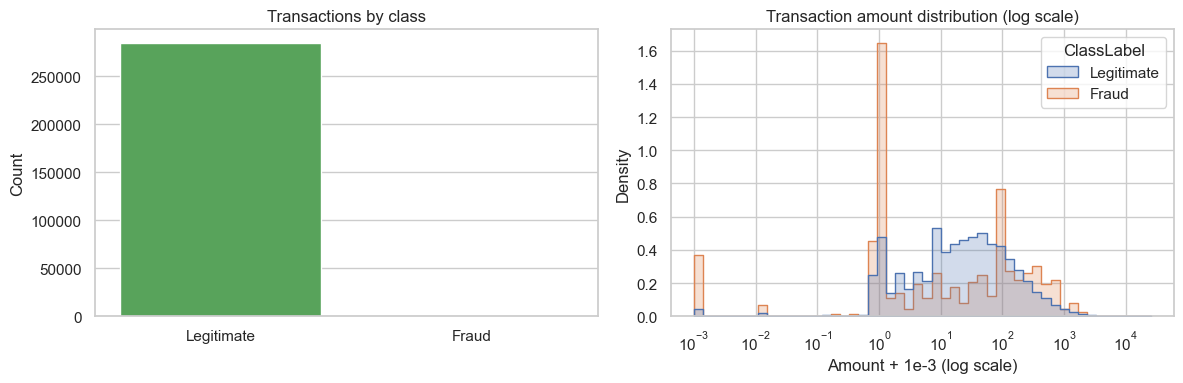

In [8]:
label_map = {0: 'Legitimate', 1: 'Fraud'}
class_counts = (
    df['Class']
    .map(label_map)
    .value_counts()
    .reindex(['Legitimate', 'Fraud'])
    .fillna(0)
)
plot_df = df.assign(ClassLabel=df['Class'].map(label_map), AmountLog=df['Amount'] + 1e-3)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    hue=class_counts.index,
    dodge=False,
    legend=False,
    palette=['#4caf50', '#f44336'],
    ax=axes[0]
)
axes[0].set_title('Transactions by class')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')

sns.histplot(
    data=plot_df,
    x='AmountLog',
    hue='ClassLabel',
    log_scale=(True, False),
    element='step',
    stat='density',
    common_norm=False,
    bins=50,
    ax=axes[1]
)
axes[1].set_title('Transaction amount distribution (log scale)')
axes[1].set_xlabel('Amount + 1e-3 (log scale)')
axes[1].set_ylabel('Density')
plt.tight_layout()

## Fraud vs. legitimate transaction stats

In [9]:
label_map = {0: 'Legitimate', 1: 'Fraud'}
amount_summary = (
    df.assign(ClassLabel=df['Class'].map(label_map))
      .groupby('ClassLabel')['Amount']
      .agg(
          count='count',
          mean='mean',
          median='median',
          std='std',
          pct_95=lambda s: s.quantile(0.95),
          max='max'
      )
      .round(2)
)
print(amount_summary)

             count    mean  median     std  pct_95       max
ClassLabel                                                  
Fraud          492  122.21    9.25  256.68  640.90   2125.87
Legitimate  284315   88.29   22.00  250.11  364.41  25691.16


### Hour-of-day patterns

In [10]:
label_map = {0: 'Legitimate', 1: 'Fraud'}
hourly = (
    df.assign(
        hour=(df['Time'] // 3600).clip(lower=0, upper=47).astype(int),
        ClassLabel=df['Class'].map(label_map)
    )
    .groupby(['hour', 'ClassLabel'])
    .size()
    .unstack(fill_value=0)
)
hourly['total'] = hourly.sum(axis=1)
hourly['fraud_rate_pct'] = (hourly['Fraud'] / hourly['total'] * 100).fillna(0).round(4)
print(hourly[['Legitimate', 'Fraud', 'fraud_rate_pct']].head())
print("\nTop hours ranked by fraud rate (%):")
print(hourly.sort_values('fraud_rate_pct', ascending=False).head(5)[['fraud_rate_pct', 'Fraud', 'Legitimate']])

ClassLabel  Legitimate  Fraud  fraud_rate_pct
hour                                         
0                 3961      2          0.0505
1                 2215      2          0.0902
2                 1555     21          1.3325
3                 1808     13          0.7139
4                 1076      6          0.5545

Top hours ranked by fraud rate (%):
ClassLabel  fraud_rate_pct  Fraud  Legitimate
hour                                         
26                  2.0548     36        1716
28                  1.5084     17        1110
2                   1.3325     21        1555
3                   0.7139     13        1808
7                   0.6829     23        3345


## PCA component signals

In [11]:
component_cols = [c for c in df.columns if c.startswith('V')]
class_means = df.groupby('Class')[component_cols].mean()
mean_shift = (class_means.loc[1] - class_means.loc[0]).abs().sort_values(ascending=False)
print('Top components by absolute mean difference between classes:')
print(mean_shift.head(10))

class_stds = df.groupby('Class')[component_cols].std()
std_ratio = (class_stds.loc[1] / class_stds.loc[0]).replace([np.inf, -np.inf], np.nan).sort_values(ascending=False)
print("\nComponents where fraud std / legit std is highest:")
print(std_ratio.head(10))

Top components by absolute mean difference between classes:
V3     7.045452
V14    6.983787
V17    6.677371
V12    6.270225
V10    5.686707
V7     5.578368
V1     4.780206
V4     4.549889
V16    4.147110
V11    3.806749
dtype: float64

Components where fraud std / legit std is highest:
V17    9.300895
V7     6.113589
V8     5.853723
V21    5.398451
V12    4.920464
V3     4.872410
V14    4.770244
V10    4.690025
V16    4.575241
V5     3.959218
dtype: float64


## Stratified train/validation split prep (no modeling yet)

In [12]:
label_map = {0: 'Legitimate', 1: 'Fraud'}
VAL_FRAC = 0.2
val_samples = []
for class_label, group in df.groupby('Class'):
    val_samples.append(group.sample(frac=VAL_FRAC, random_state=42))
val_df = pd.concat(val_samples).sort_index()
train_df = df.drop(val_df.index)

def summarize_split(name, data):
    counts = data['Class'].value_counts().sort_index()
    percent = (counts / len(data) * 100).round(4)
    summary = pd.DataFrame({
        'Class Label': counts.index.map({0: 'Legitimate', 1: 'Fraud'}),
        'Count': counts.values,
        'Percent': percent.values,
    })
    print(f"{name} -> {len(data):,} rows")
    print(summary.to_string(index=False))

summarize_split('Train', train_df)
print()
summarize_split('Validation', val_df)

Train -> 227,846 rows
Class Label  Count  Percent
 Legitimate 227452  99.8271
      Fraud    394   0.1729

Validation -> 56,961 rows
Class Label  Count  Percent
 Legitimate  56863   99.828
      Fraud     98    0.172


## Modeling setup

In [13]:
FEATURES = [col for col in df.columns if col != 'Class']
TARGET = 'Class'

X_train = train_df[FEATURES].copy()
y_train = train_df[TARGET].copy()
X_val = val_df[FEATURES].copy()
y_val = val_df[TARGET].copy()

print(f'Total features: {len(FEATURES)}')
print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}')

Total features: 30
Train shape: (227846, 30), Validation shape: (56961, 30)


### Helper utilities

In [14]:
import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    confusion_matrix,
    precision_recall_curve,
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def evaluate_model(estimator, X, y, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    rows = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        model = clone(estimator)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        proba = model.predict_proba(X.iloc[val_idx])[:, 1]
        preds = (proba >= 0.5).astype(int)
        rows.append({
            'fold': fold,
            'roc_auc': roc_auc_score(y.iloc[val_idx], proba),
            'pr_auc': average_precision_score(y.iloc[val_idx], proba),
            'recall@0.5': recall_score(y.iloc[val_idx], preds, zero_division=0),
            'precision@0.5': precision_score(y.iloc[val_idx], preds, zero_division=0),
        })
    return pd.DataFrame(rows)


def summarize_holdout(name, estimator, X, y, threshold=0.5):
    proba = estimator.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)
    metrics = {
        'roc_auc': roc_auc_score(y, proba),
        'pr_auc': average_precision_score(y, proba),
        'precision': precision_score(y, preds, zero_division=0),
        'recall': recall_score(y, preds, zero_division=0),
    }
    print(f"{name} @ threshold {threshold:.2f}")
    print(metrics)
    print('Confusion matrix:')
    print(confusion_matrix(y, preds))
    return proba

### Logistic regression (class-weighted baseline)

In [15]:
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')),
])

log_cv = evaluate_model(log_reg, X_train, y_train)
print('5-fold CV metrics:')
print(log_cv.round(4))
print('CV mean:', log_cv.mean().round(4).to_dict())

log_reg.fit(X_train, y_train)
log_val_proba = summarize_holdout('Logistic regression holdout', log_reg, X_val, y_val)


5-fold CV metrics:
   fold  roc_auc  pr_auc  recall@0.5  precision@0.5
0     1   0.9839  0.7335      0.9160         0.0690
1     2   0.9584  0.7447      0.8712         0.0637
2     3   0.9847  0.7029      0.9160         0.0677
CV mean: {'fold': 2.0, 'roc_auc': 0.9756, 'pr_auc': 0.727, 'recall@0.5': 0.9011, 'precision@0.5': 0.0668}
Logistic regression holdout @ threshold 0.50
{'roc_auc': np.float64(0.9905456616637124), 'pr_auc': np.float64(0.737453056716458), 'precision': 0.06803218727139722, 'recall': 0.9489795918367347}
Confusion matrix:
[[55589  1274]
 [    5    93]]


### Random forest (class-weighted baseline)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=10,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42,
    )),
])

rf_cv = evaluate_model(rf, X_train, y_train)
print('5-fold CV metrics:')
print(rf_cv.round(4))
print('CV mean:', rf_cv.mean().round(4).to_dict())

rf.fit(X_train, y_train)
rf_val_proba = summarize_holdout('Random forest holdout', rf, X_val, y_val)


5-fold CV metrics:
   fold  roc_auc  pr_auc  recall@0.5  precision@0.5
0     1   0.9731  0.8281      0.8168         0.8295
1     2   0.9637  0.8120      0.7955         0.8537
2     3   0.9814  0.7941      0.8321         0.8134
CV mean: {'fold': 2.0, 'roc_auc': 0.9728, 'pr_auc': 0.8114, 'recall@0.5': 0.8148, 'precision@0.5': 0.8322}
Random forest holdout @ threshold 0.50
{'roc_auc': np.float64(0.9870499700856372), 'pr_auc': np.float64(0.8379818212694822), 'precision': 0.801980198019802, 'recall': 0.826530612244898}
Confusion matrix:
[[56843    20]
 [   17    81]]


### Threshold tuning (logistic holdout)

In [17]:
target_recall = 0.80
precisions, recalls, thresholds = precision_recall_curve(y_val, log_val_proba)
pr_df = pd.DataFrame({
    'threshold': np.append(thresholds, 1.0),
    'precision': precisions,
    'recall': recalls,
})
candidates = pr_df[pr_df['recall'] >= target_recall]
if not candidates.empty:
    best = candidates.sort_values('precision', ascending=False).head(1)
    print('Best threshold achieving >= {:.0%} recall:'.format(target_recall))
    print(best)
    tuned_threshold = float(best['threshold'].iloc[0])
    _ = summarize_holdout('LogReg tuned holdout', log_reg, X_val, y_val, threshold=tuned_threshold)
else:
    print('No threshold reached the target recall; default 0.5 metrics shown above.')


Best threshold achieving >= 80% recall:
       threshold  precision    recall
56798   0.997636   0.683761  0.816327
LogReg tuned holdout @ threshold 1.00
{'roc_auc': np.float64(0.9905456616637124), 'pr_auc': np.float64(0.737453056716458), 'precision': 0.6837606837606838, 'recall': 0.8163265306122449}
Confusion matrix:
[[56826    37]
 [   18    80]]


### Feature importance snapshots

In [18]:
log_coefs = pd.Series(
    log_reg.named_steps['clf'].coef_[0],
    index=FEATURES,
).abs().sort_values(ascending=False).head(10)
print('Logistic regression top |coef| features:')
print(log_coefs)

rf_importances = pd.Series(
    rf.named_steps['clf'].feature_importances_,
    index=FEATURES,
).sort_values(ascending=False).head(10)
print('\nRandom forest feature importances:')
print(rf_importances)


Logistic regression top |coef| features:
Amount    1.939817
V14       1.354645
V1        1.326608
V4        1.062787
V12       1.052123
V5        0.930302
V2        0.863589
V17       0.740976
V10       0.700566
V16       0.689385
dtype: float64

Random forest feature importances:
V14    0.176029
V10    0.114174
V4     0.113061
V12    0.102183
V17    0.093888
V3     0.061476
V11    0.057728
V16    0.052445
V2     0.031020
V7     0.025695
dtype: float64


## Next steps toward modeling

- Calibrate decision thresholds with business cost matrices + drift monitoring.
- Add SHAP/global interpretability dashboards to explain high-variance PCA components.
- Package the winning pipeline for the FastAPI service and regression tests.
